In [1]:
import SCOTCH
import pandas as pd 
import numpy as np 
import anndata as ad
import scanpy as sc
import pooch
import pyEnrichAnalyzer

import torch

import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec

### Loading single cell data 

SCOTCH allows loading through three interfaces, plain text files, anndata objects, or pytorch pt. files. For this example we will work with the exampledata scat is used for the scverse and scanpy tutorials. The data that are using is the 2021 NeurIPS benchmarking dataset. The samples used in this data were measured with the 10X multiome gene expression and chromatin accessibility kit. We will focus on the filtered expression matrices. That data contains ~16,000 from two different donors and span 36,601 genes. 

For this tutorial we utilize the beginning of the guide for scanpy which downloads the data into a standard adata object (adata). 

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [3]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())

/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


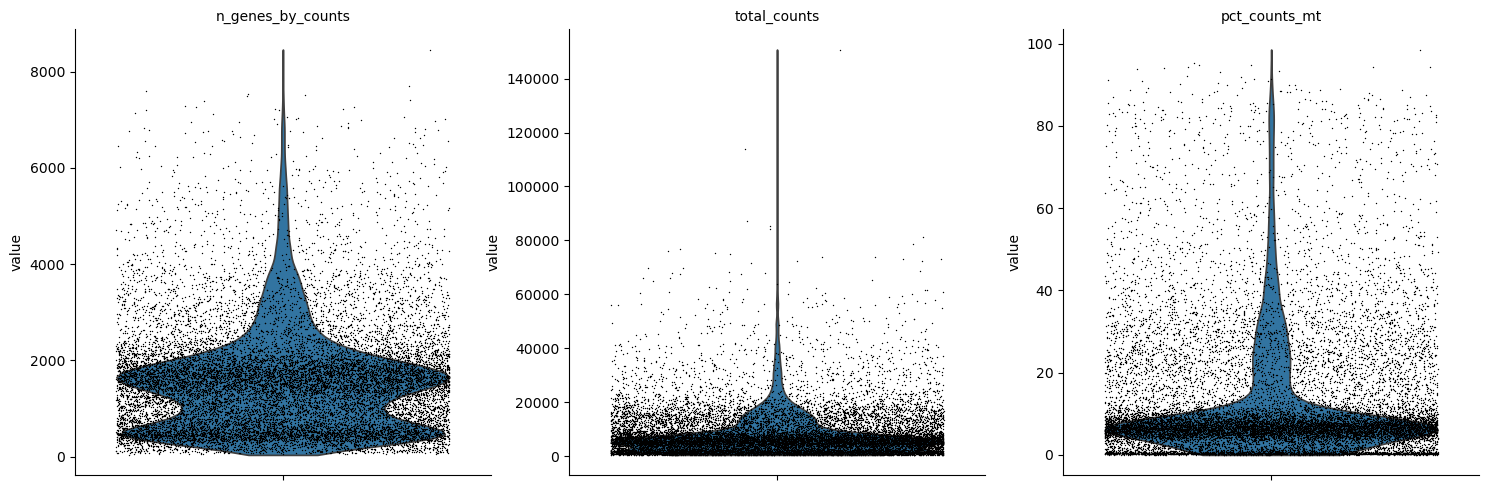

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

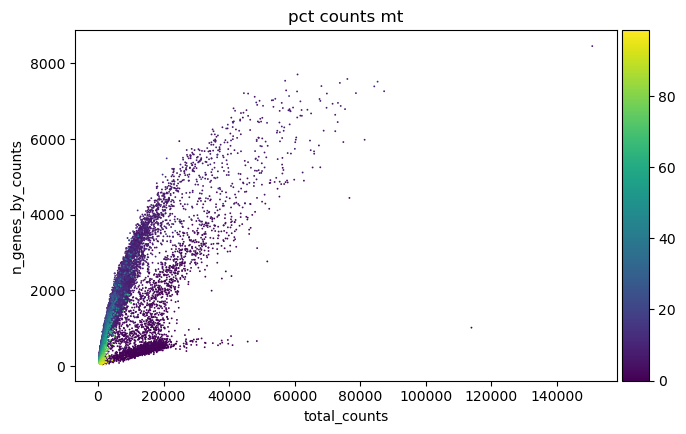

In [5]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
#sc.pp.scrublet(adata, batch_key="sample")

In [7]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
adata_high_var= adata[:, adata.var["highly_variable"]]

### Initializing a SCOTCH object

Now we can initialize SCOTCH. SCOTCH is a matrix tri factorization approach that estimates the data as multiplication of three matrices. 

$X \approx U S V^{T}$ where $U$ is a near orthogonal matrix which is used to cluster the cell space, $V$ is a near orthogonal matrix which is used to cluster the gene space, and $S$ is relationship matrix which relates gene and cell clusters. 

To start SCOTCH we need to initialize a SCOTCH object, and specify the number of cluster we want to use for the cell space (k1), and the number of cluster for the gene space (k2). We can also specify regularization parameters such as $\lambda_u$ or $\lambda_v$ which can be tuned to improve the orthogonality of the cell and gene clusters respectively. 


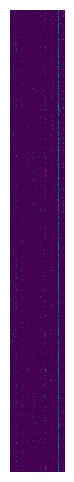

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
X_dense = adata_high_var.X.toarray() if hasattr(adata_high_var.X, 'toarray') else adata_high_var.X
ax.imshow(X_dense, interpolation="nearest", cmap = 'viridis')
ax.set_axis_off()

In [10]:
scotch = SCOTCH.SCOTCH(k1 = 15, k2 = 30, max_l_u = 0.10, max_l_v = 0.10, term_tol = 1e-10, var_lambda= False, device = "cpu", init_style= "random", verbose = True)
scotch.add_data_from_adata(adata_high_var)
#scotch.send_to_gpu()


AttributeError: 'SCOTCH' object has no attribute 'addDataFromAData'

In [ ]:
scotch.fit()

In [ ]:
scotch.send_to_cpu()
scotch.assign_cluster()
adata_high_var = scotch.add_scotch_embeddings_to_adata(adata_high_var)

In [ ]:
adata_high_var

In [ ]:
scotch.visualize_factors()

In [ ]:
scotch.visualize_factors_sorted()

In [ ]:
sc.pp.pca(adata_high_var) 

In [ ]:
sc.pp.neighbors(adata_high_var, use_rep= "X_pca", metric = "cosine")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

In [ ]:
sc.pp.neighbors(adata_high_var, use_rep= "cell_embedding")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

In [ ]:
sc.pp.neighbors(adata_high_var, use_rep= "P_embedding")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

In [ ]:
EA = pyEnrichAnalyzer.Framework()
EA.runEnrichAnalyzer(adata_high_var.var.to_dict(orient='index'), "gene_cluster", adata_high_var.var_names.to_list(),  )


In [ ]:
adata_high_var.var_names.tolist()

In [ ]:
scotch.send_to_gpu()
scotch.reclusterV()

In [ ]:
scotch.send_to_cpu()
scotch.assign_cluster()
scotch.visualizeClusters()
scotch.visualizeFactors()
scotch.visualizeFactorsSorted()

In [ ]:
adata_high_var = scotch.addScotchEmbeddingsToAnnData(adata_high_var)
sc.pp.neighbors(adata_high_var, use_rep= "X_pca")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

In [ ]:
scotch_no_reg = SCOTCH.SCOTCH(k1 = 15, k2 = 30, max_l_u = 0.0, max_l_v = 0.0, term_tol = 1e-10, var_lambda= False, device = "cuda:0", init_style= "random", verbose = True)
scotch_no_reg.addDataFromAData(adata_high_var)
scotch_no_reg.send_to_gpu()


In [ ]:
scotch_no_reg.fit()

In [ ]:
scotch_no_reg.send_to_cpu()
scotch_no_reg.assign_cluster()
adata_high_var = scotch_no_reg.addScotchEmbeddingsToAnnData(adata_high_var)

In [ ]:
scotch_no_reg.visualizeClustersSorted()

In [ ]:
scotch_no_reg.visualizeFactorsSorted()